In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, generate_testing_mixup_images, find_boundary_points
from plotting_functions import plot_3_confusion_matricies, plot_calibration, muba_curves
import pandas as pd


In [2]:
data_flag = 'octmnist'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [3]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz


In [4]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=4, image_size = 28)


In [5]:
# As a sanity check to make sure we have the correct test data, check counts

get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal'])


Train
{(0, 0, 0, 1): 46026, (0, 0, 1, 0): 7754, (0, 1, 0, 0): 10213, (1, 0, 0, 0): 33484}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Val
{(0, 0, 0, 1): 5114, (0, 0, 1, 0): 862, (0, 1, 0, 0): 1135, (1, 0, 0, 0): 3721}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test A
{(0, 0, 0, 1): 69, (0, 0, 1, 0): 72, (0, 1, 0, 0): 80, (1, 0, 0, 0): 79}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test B
{(0, 0, 0, 1): 181, (0, 0, 1, 0): 178, (0, 1, 0, 0): 170, (1, 0, 0, 0): 171}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


In [6]:
test_set_A_df = pd.DataFrame({
    "image_index":[i for i in range(len(y_test_A))],
    "class":[np.argmax(label) for label in y_test_A]}) # 0 if normal, 1 if pneumonia

In [7]:
MUBA_ITERS = 20

muba_df = generate_testing_mixup_images(test_set_A_df, X_test_A, MUBA_ITERS, classes=4)

In [8]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.019174,0.980826,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[35.29487336896341], [28.42908816174351], [2...",mix,1
1,0.062954,0.937046,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[45.10160110800197], [38.54227614262704], [3...",mix,1
2,0.100747,0.899253,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[53.5672372764698], [47.27246344135948], [43...",mix,1
3,0.179674,0.820326,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[71.24705747609758], [65.50477802222564], [6...",mix,1
4,0.204100,0.795900,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[76.71835967479161], [71.14705841462884], [6...",mix,1
...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.540121,0.459879,NaN,NaN,281.0,299.0,"[[[20.08024112438995], [21.54012056219498], [2...",mix,2
674131,0.000000,0.000000,0.557495,0.442505,NaN,NaN,281.0,299.0,"[[[20.11498942830472], [21.557494714152362], [...",mix,2
674132,0.000000,0.000000,0.604812,0.395188,NaN,NaN,281.0,299.0,"[[[20.209623133059846], [21.604811566529925], ...",mix,2
674133,0.000000,0.000000,0.666593,0.333407,NaN,NaN,281.0,299.0,"[[[20.333185539408543], [21.66659276970427], [...",mix,2


In [9]:
model = keras.models.load_model("best_model_epoch_13.h5")
activations_model = keras.Model(model.input,model.layers[-2].output)

In [10]:
predictions_A = model.predict(X_test_A)
activations_A = activations_model.predict(X_test_A)

predictions_B = model.predict(X_test_B)
activations_B = activations_model.predict(X_test_B)

print("Stacking - this can take some time.")
stacked_images = np.stack(muba_df["image"])
predictions_mixup = model.predict(stacked_images)
activations_mixup = activations_model.predict(stacked_images)

22/22 [==============================] - 0s 7ms/step
Stacking - this can take some time.
21067/21067 [==============================] - 163s 8ms/step


In [11]:
muba_df["predictions_0"] = [p[0] for p in predictions_mixup]
muba_df["predictions_1"] = [p[1] for p in predictions_mixup]
muba_df["predictions_2"] = [p[2] for p in predictions_mixup]
muba_df["predictions_3"] = [p[3] for p in predictions_mixup]
muba_df["argmax_pred"] = [np.argmax(p) for p in predictions_mixup]
muba_df["activations"] = [a for a in activations_mixup]

In [12]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations
0,0.019174,0.980826,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[35.29487336896341], [28.42908816174351], [2...",mix,1,0.014677,0.967412,0.001908,0.016003,1,"[0.0, 0.0, 0.25227228, 0.43363804, 0.82478505,..."
1,0.062954,0.937046,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[45.10160110800197], [38.54227614262704], [3...",mix,1,0.021011,0.949029,0.003520,0.026440,1,"[0.0, 0.0, 0.27478084, 0.4467436, 0.88904256, ..."
2,0.100747,0.899253,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[53.5672372764698], [47.27246344135948], [43...",mix,1,0.031739,0.922451,0.005716,0.040094,1,"[0.0, 0.0, 0.2549383, 0.3977624, 0.9123422, 0...."
3,0.179674,0.820326,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[71.24705747609758], [65.50477802222564], [6...",mix,1,0.087824,0.817096,0.012892,0.082189,1,"[0.0, 0.0, 0.20944636, 0.15607077, 0.88975465,..."
4,0.204100,0.795900,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[76.71835967479161], [71.14705841462884], [6...",mix,1,0.113532,0.772451,0.017359,0.096658,1,"[0.0, 0.0, 0.18953837, 0.06875804, 0.824348, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.540121,0.459879,NaN,NaN,281.0,299.0,"[[[20.08024112438995], [21.54012056219498], [2...",mix,2,0.493578,0.012073,0.052820,0.441528,0,"[0.0, 0.6902232, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20..."
674131,0.000000,0.000000,0.557495,0.442505,NaN,NaN,281.0,299.0,"[[[20.11498942830472], [21.557494714152362], [...",mix,2,0.507471,0.011405,0.050738,0.430385,0,"[0.025974728, 0.70151305, 0.0, 0.0, 0.0, 0.0, ..."
674132,0.000000,0.000000,0.604812,0.395188,NaN,NaN,281.0,299.0,"[[[20.209623133059846], [21.604811566529925], ...",mix,2,0.545645,0.010511,0.051712,0.392132,0,"[0.120377526, 0.6832229, 0.0, 0.0, 0.0, 0.0, 0..."
674133,0.000000,0.000000,0.666593,0.333407,NaN,NaN,281.0,299.0,"[[[20.333185539408543], [21.66659276970427], [...",mix,2,0.577298,0.010757,0.069698,0.342247,0,"[0.23369795, 0.6007024, 0.0, 0.0, 0.0, 0.0, 0...."


(array([174590.,      0.,      0., 176000.,      0.,      0., 164160.,
             0.,      0., 159390.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

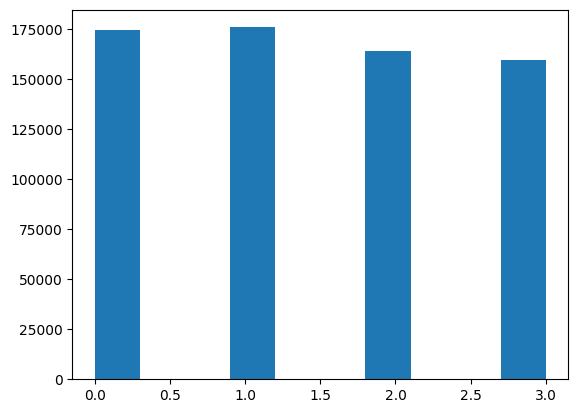

In [13]:
plt.hist(muba_df["label"])

In [14]:
# Check this works
boundary_points_df = find_boundary_points(muba_df, X_test_A, MUBA_ITERS, classes = 4)

In [15]:
boundary_points_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.430564,0.569436,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[127.44641609972783], [123.46036660284432], ...",boundary,1
1,0.247359,0.752641,0.000000,0.000000,1.0,2.0,NaN,NaN,"[[[98.45072197056257], [94.68751817177802], [9...",boundary,1
2,0.235236,0.000000,0.764764,0.000000,1.0,NaN,4.0,NaN,"[[[98.98811102082064], [99.75287518248328], [1...",boundary,2
3,0.430687,0.569313,0.000000,0.000000,1.0,5.0,NaN,NaN,"[[[255.0], [255.0], [255.0], [254.0], [253.569...",boundary,1
4,0.445423,0.000000,0.000000,0.554577,1.0,NaN,NaN,6.0,"[[[126.3380743224301], [125.78349705657851], [...",boundary,3
...,...,...,...,...,...,...,...,...,...,...,...
42863,0.000000,0.000000,0.513826,0.486174,NaN,NaN,281.0,264.0,"[[[27.320267925821845], [27.347919014156947], ...",boundary,2
42864,0.000000,0.000000,0.409023,0.590977,NaN,NaN,281.0,269.0,"[[[28.68270730737574], [28.50075233701024], [2...",boundary,3
42865,0.000000,0.000000,0.528798,0.471202,NaN,NaN,281.0,276.0,"[[[83.19868923823145], [84.66989142943017], [8...",boundary,2
42866,0.000000,0.000000,0.472727,0.527273,NaN,NaN,281.0,286.0,"[[[22.054546713242047], [22.527273356621023], ...",boundary,3


In [16]:
predictions_boundary = model.predict(np.stack(boundary_points_df["image"]))
activations_boundary = activations_model.predict(np.stack(boundary_points_df["image"]))

1340/1340 [==============================] - 10s 8ms/step


In [17]:
test_set_A_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_A],
    "alpha_class_1" : [label[1] for label in y_test_A],
    "alpha_class_2" : [label[2] for label in y_test_A],
    "alpha_class_3" : [label[3] for label in y_test_A],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_A],
    "type" : "A",
    "label" : [np.argmax(l) for l in y_test_A],
    "predictions_0" : [p[0] for p in predictions_A],
    "predictions_1" : [p[1] for p in predictions_A],
    "predictions_2" : [p[2] for p in predictions_A],
    "predictions_3" : [p[3] for p in predictions_A],
    "argmax_pred" : [np.argmax(p) for p in predictions_A],
    "activations" : [a for a in activations_A]
})
test_set_B_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_B],
    "alpha_class_1" : [label[1] for label in y_test_B],
    "alpha_class_2" : [label[2] for label in y_test_B],
    "alpha_class_3" : [label[3] for label in y_test_B],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_B],
    "type" : "B",
    "label" : [np.argmax(l) for l in y_test_B],
    "predictions_0" : [p[0] for p in predictions_B],
    "predictions_1" : [p[1] for p in predictions_B],
    "predictions_2" : [p[2] for p in predictions_B],
    "predictions_3" : [p[3] for p in predictions_B],
    "argmax_pred" : [np.argmax(p) for p in predictions_B],
    "activations" : [a for a in activations_B]
})

boundary_points_df["predictions_0"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_1"] = [p[1] for p in predictions_boundary]
boundary_points_df["predictions_2"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_3"] = [p[1] for p in predictions_boundary]
boundary_points_df["argmax_pred"] = [np.argmax(p) for p in predictions_boundary]
boundary_points_df["activations"] = [a for a in activations_boundary]

In [18]:
df = pd.concat([test_set_A_df, test_set_B_df, muba_df, boundary_points_df],axis=0, ignore_index=True)

In [19]:
muba_projections = TSNE(2,random_state=1, verbose = 2).fit_transform(np.stack(df["activations"]))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 718013 samples in 0.049s...
[t-SNE] Computed neighbors for 718013 samples in 1967.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 718013
[t-SNE] Computed conditional probabilities for sample 2000 / 718013
[t-SNE] Computed conditional probabilities for sample 3000 / 718013
[t-SNE] Computed conditional probabilities for sample 4000 / 718013
[t-SNE] Computed conditional probabilities for sample 5000 / 718013
[t-SNE] Computed conditional probabilities for sample 6000 / 718013
[t-SNE] Computed conditional probabilities for sample 7000 / 718013
[t-SNE] Computed conditional probabilities for sample 8000 / 718013
[t-SNE] Computed conditional probabilities for sample 9000 / 718013
[t-SNE] Computed conditional probabilities for sample 10000 / 718013
[t-SNE] Computed conditional probabilities for sample 11000 / 718013
[t-SNE] Computed conditional probabilities for sample 12000 / 718013
[t-SNE] Computed conditional prob

In [20]:
df["projection_x"] = [x[0] for x in muba_projections]
df["projection_y"] = [x[1] for x in muba_projections]

In [21]:
df_to_save = df.drop(columns=["image"])
df_to_save.to_pickle("muba_df.csv")

In [2]:
df = pd.read_pickle("muba_df.csv")

In [3]:
true_images_A_df = df[df["type"] == "A"]
true_images_B_df = df[df["type"] == "B"]

mixup_images_df =  df[df["type"] == "mix"]
boundary_images_df = df[df["type"] == "boundary"]

true_A_class_0 = true_images_A_df[true_images_A_df["label"] == 0]
true_A_class_1 = true_images_A_df[true_images_A_df["label"] == 1]
true_A_class_2 = true_images_A_df[true_images_A_df["label"] == 2]
true_A_class_3 = true_images_A_df[true_images_A_df["label"] == 3]

true_B_class_0 = true_images_B_df[true_images_B_df["label"] == 0]
true_B_class_1 = true_images_B_df[true_images_B_df["label"] == 1]
true_B_class_2 = true_images_B_df[true_images_B_df["label"] == 2]
true_B_class_3 = true_images_B_df[true_images_B_df["label"] == 3]

mixup_0 = mixup_images_df[mixup_images_df["label"] == 0]
mixup_1 = mixup_images_df[mixup_images_df["label"] == 1]
mixup_2 = mixup_images_df[mixup_images_df["label"] == 2]
mixup_3 = mixup_images_df[mixup_images_df["label"] == 3]

true_A_errors = true_images_A_df[true_images_A_df["label"] != true_images_A_df["argmax_pred"]]
true_B_errors = true_images_B_df[true_images_B_df["label"] != true_images_B_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_A_class_0 = true_A_class_0[true_A_class_0["label"] == true_A_class_0["argmax_pred"]]
error_free_true_A_class_1 = true_A_class_1[true_A_class_1["label"] == true_A_class_1["argmax_pred"]]
error_free_true_A_class_2 = true_A_class_2[true_A_class_2["label"] == true_A_class_2["argmax_pred"]]
error_free_true_A_class_3 = true_A_class_3[true_A_class_3["label"] == true_A_class_3["argmax_pred"]]

error_free_mixup_class_0 = mixup_0[mixup_0["label"] == mixup_0["argmax_pred"]]
error_free_mixup_class_1 = mixup_1[mixup_1["label"] == mixup_1["argmax_pred"]]
error_free_mixup_class_2 = mixup_2[mixup_2["label"] == mixup_2["argmax_pred"]]
error_free_mixup_class_3 = mixup_3[mixup_3["label"] == mixup_3["argmax_pred"]]

In [4]:
true_images_B_df

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations,projection_x,projection_y
300,1.0,0.0,0.0,0.0,None,None,None,None,B,0,0.908489,0.053562,0.006072,0.031877,0,"[0.0, 0.14003149, 0.0, 0.0, 0.8285757, 0.16085...",-67.576889,37.896946
301,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.694294,0.024395,0.025784,0.255528,0,"[0.0, 0.5532235, 0.48653328, 0.0, 0.0, 0.04140...",19.106361,39.186909
302,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.021374,0.005175,0.008875,0.964577,3,"[0.0, 0.0, 0.85847217, 1.446691, 0.0, 0.0, 0.6...",100.988365,-57.732765
303,0.0,1.0,0.0,0.0,None,None,None,None,B,1,0.804352,0.149133,0.003695,0.042820,0,"[0.0, 0.41806564, 0.37752166, 0.0, 0.27032122,...",-29.668125,107.533730
304,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.011088,0.005789,0.068969,0.914154,3,"[0.4084303, 0.0, 0.8622807, 0.40942147, 0.3644...",46.031696,-101.955292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.284552,0.016595,0.080724,0.618130,3,"[0.18701985, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3...",12.217535,-47.345158
996,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.119007,0.001019,0.790507,0.089468,2,"[0.0, 0.4411892, 0.0, 0.0, 0.0, 0.0, 0.5613346...",24.734837,-95.861931
997,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.003881,0.000467,0.992099,0.003553,2,"[0.0, 0.0, 0.0, 0.077158, 0.0, 0.6842822, 0.24...",22.317699,-106.715843
998,1.0,0.0,0.0,0.0,None,None,None,None,B,0,0.945106,0.023030,0.011561,0.020303,0,"[0.0, 0.28701726, 0.00027262513, 0.0, 0.232609...",-89.875084,78.630432


In [5]:
mixup_errors_0_1 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_1"] > 0)]
mixup_errors_0_2 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_0_3 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_1_2 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_1_3 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_2_3 = mixup_errors[(mixup_errors["alpha_class_2"] > 0) & (mixup_errors["alpha_class_3"] > 0)]

boundaries_0_1 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_1"] > 0)]
boundaries_0_2 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_0_3 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_1_2 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_1_3 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_2_3 = boundary_images_df[(boundary_images_df["alpha_class_2"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]

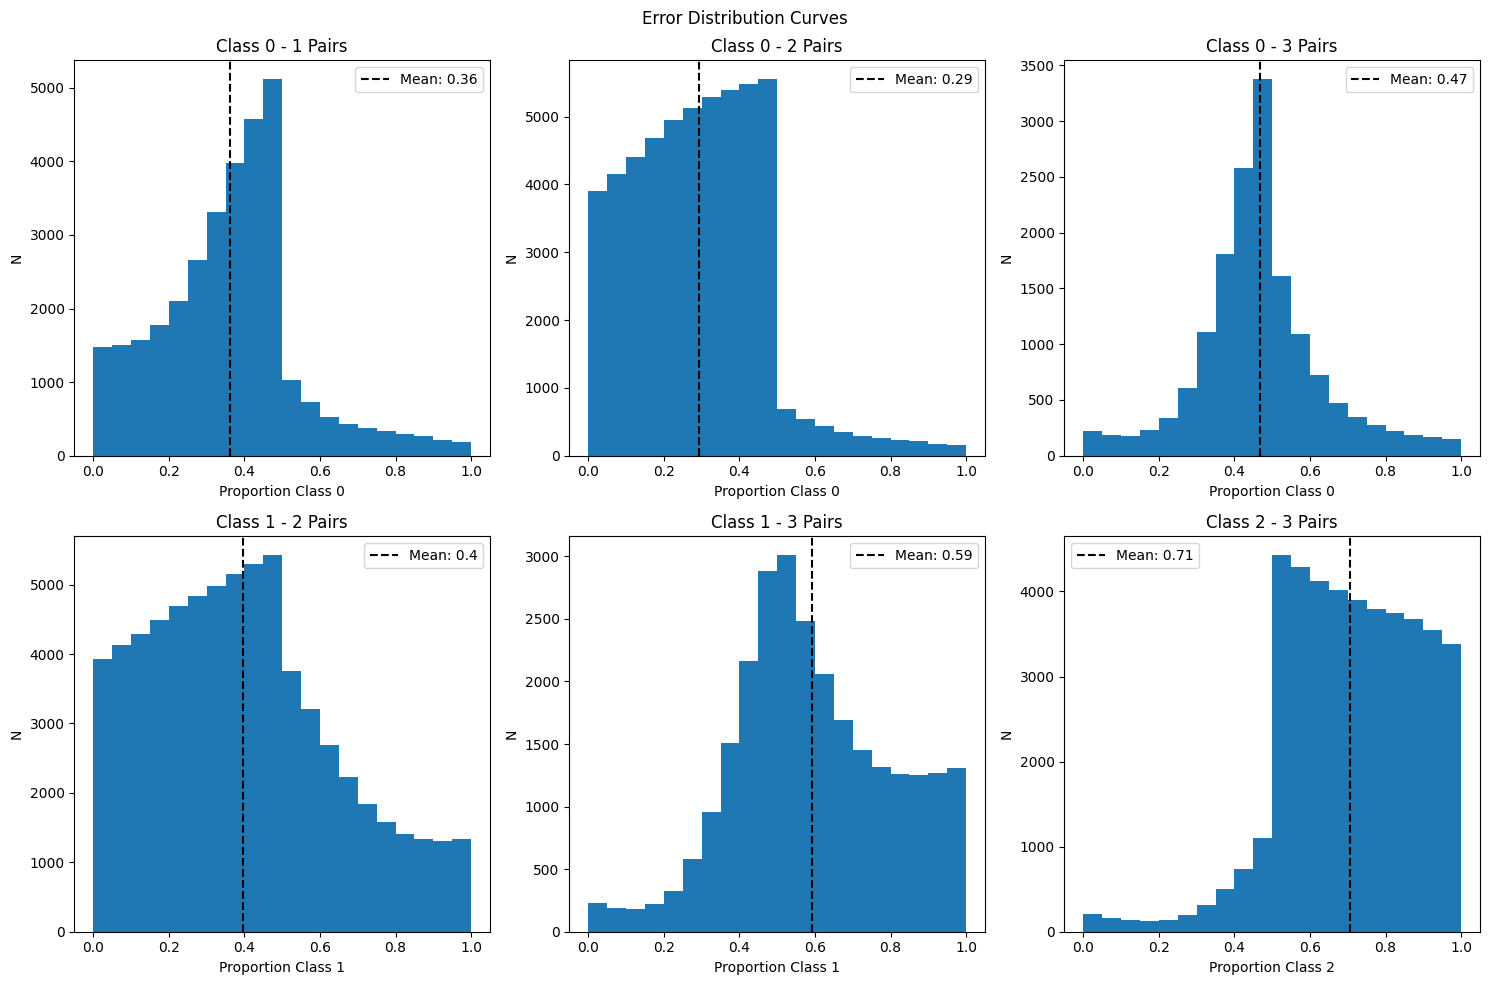

In [6]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [mixup_errors_0_1,mixup_errors_0_2,mixup_errors_0_3,mixup_errors_1_2,mixup_errors_1_3,mixup_errors_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)])
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Error Distribution Curves")
fig.tight_layout()

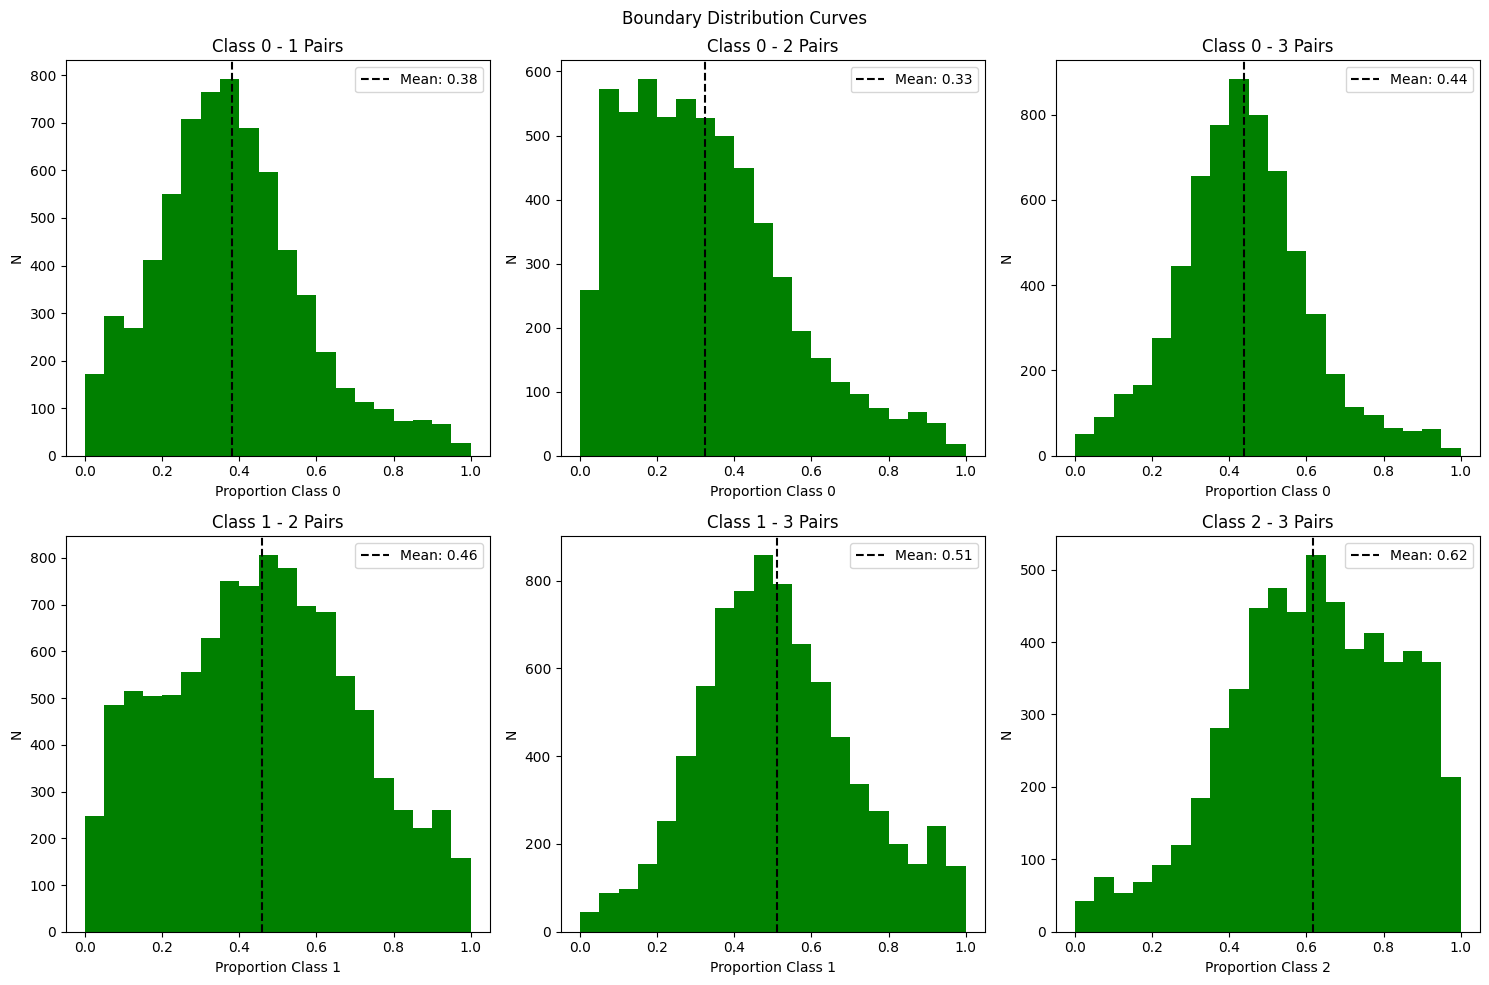

In [7]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [boundaries_0_1,boundaries_0_2,boundaries_0_3,boundaries_1_2,boundaries_1_3,boundaries_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)], color="green")
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Boundary Distribution Curves")
fig.tight_layout()

In [8]:
print(classification_report(mixup_images_df["label"],mixup_images_df["argmax_pred"]))

              precision    recall  f1-score   support

           0       0.55      0.93      0.69    174590
           1       0.87      0.63      0.73    176000
           2       0.80      0.18      0.29    164160
           3       0.63      0.85      0.72    159390

    accuracy                           0.65    674140
   macro avg       0.71      0.65      0.61    674140
weighted avg       0.71      0.65      0.61    674140



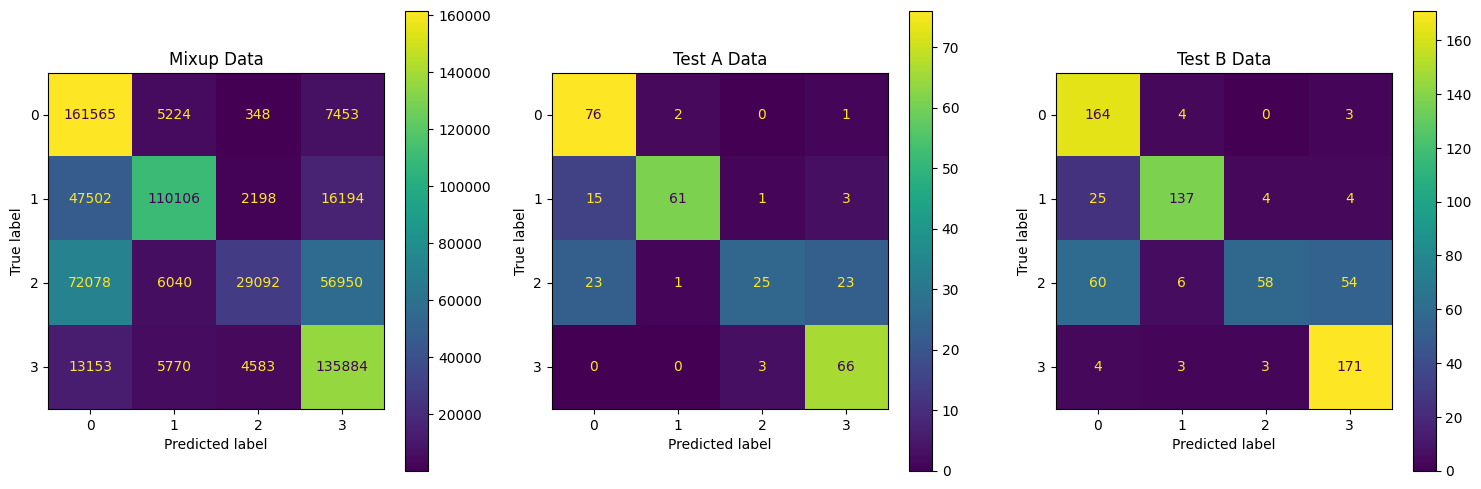

In [9]:
plot_3_confusion_matricies(mixup_images_df,true_images_A_df,true_images_B_df, labels = [0,1,2,3])

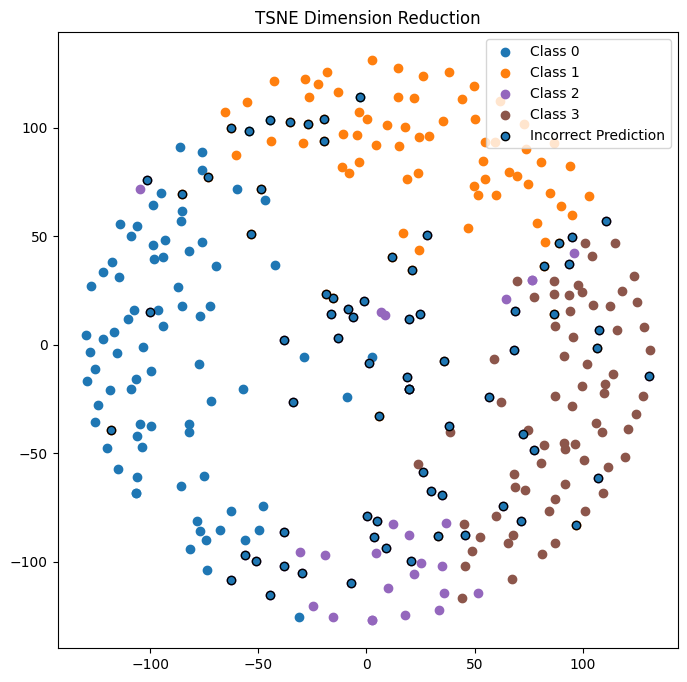

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


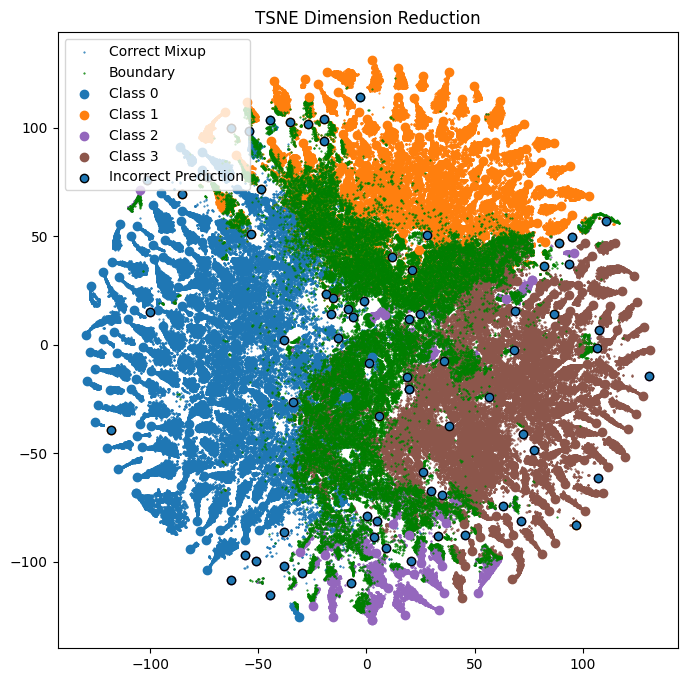

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [12]:
from scipy import spatial
from collections import Counter

def get_distances():

    all_images_without_B_df = df[df["type"] != "B"].reset_index()
    activations_A = [a for a in true_images_A_df["activations"]]
    activations_B = [a for a in true_images_B_df["activations"]]
    activations_mixup = [a for a in mixup_images_df["activations"]]
    activations_boundary = [a for a in boundary_images_df["activations"]]
    all = [a for a in all_images_without_B_df["activations"]]

    tree_true_A = spatial.KDTree(activations_A)
    tree_true_B = spatial.KDTree(activations_B)
    tree_mixup  = spatial.KDTree(activations_mixup)
    tree_boundaries = spatial.KDTree(activations_boundary)
    tree_all = spatial.KDTree(all)

    distances_to_all = []
    distances_B_to_boundary = []
    distances_B_to_mixup = []
    B_class_0_to_boundary = []
    B_class_1_to_boundary = []
    B_class_2_to_boundary = []
    B_class_3_to_boundary = []
    B_class_0_correct_to_boundary = []
    B_class_1_correct_to_boundary = []
    B_class_2_correct_to_boundary = []
    B_class_3_correct_to_boundary = []
    B_class_0_incorrect_to_boundary = []
    B_class_1_incorrect_to_boundary = []
    B_class_2_incorrect_to_boundary = []
    B_class_3_incorrect_to_boundary = []
    types = []
    distance_B_to_B = []
    
    distances_A_to_boundary = []
    A_class_0_to_boundary = []
    A_class_1_to_boundary = []
    A_class_2_to_boundary = []
    A_class_3_to_boundary = []
    A_class_0_incorrect_to_boundary = []
    A_class_1_incorrect_to_boundary = []
    A_class_2_incorrect_to_boundary = []
    A_class_3_incorrect_to_boundary = []
    distance_A_to_A = []

    for vector, label, pred in zip(activations_B,true_images_B_df["label"],true_images_B_df["argmax_pred"]):

        distance, id = tree_all.query(vector)
        types.append(all_images_without_B_df.loc[[id]]["type"][id])
        distances_to_all.append(distance)

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_B_to_B.append(tree_true_B.query(vector,2)[0][1])
        distances_B_to_boundary.append(boundary_dist)
        distances_B_to_mixup.append(tree_mixup.query(vector)[0])

        if label == 0:
            B_class_0_to_boundary.append(boundary_dist)
            if pred != 0:#Incorrect
                B_class_0_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_0_correct_to_boundary.append(boundary_dist)
        elif label == 1:
            B_class_1_to_boundary.append(boundary_dist)
            if pred != 1:#Incorrect
                B_class_1_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_1_correct_to_boundary.append(boundary_dist)
        elif label == 2:
            B_class_2_to_boundary.append(boundary_dist)
            if pred != 2:#Incorrect
                B_class_2_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_2_correct_to_boundary.append(boundary_dist)
        elif label == 3:
            B_class_3_to_boundary.append(boundary_dist)
            if pred != 3:#Incorrect
                B_class_3_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_3_correct_to_boundary.append(boundary_dist)

    for vector, label, pred in zip(activations_A, true_images_A_df["label"],true_images_A_df["argmax_pred"]):

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_A_to_A.append(tree_true_A.query(vector,2)[0][1])
        distances_A_to_boundary.append(boundary_dist)

        if label == 0:
            A_class_0_to_boundary.append(boundary_dist)
            if pred != 0: #Incorrect
                A_class_0_incorrect_to_boundary.append(boundary_dist)
        elif label == 1:
            A_class_1_to_boundary.append(boundary_dist)
            if pred != 1: #Incorrect
                A_class_1_incorrect_to_boundary.append(boundary_dist)
        elif label == 2:
            A_class_2_to_boundary.append(boundary_dist)
            if pred != 2: #Incorrect
                A_class_2_incorrect_to_boundary.append(boundary_dist)
        elif label == 3:
            A_class_3_to_boundary.append(boundary_dist)
            if pred != 3:#Incorrect
                A_class_3_incorrect_to_boundary.append(boundary_dist)

    counts = Counter(types)

   
    return distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary

In [13]:
distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary = get_distances()


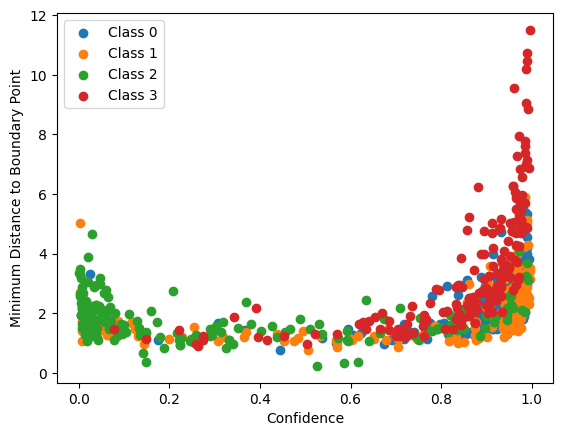

In [14]:
plt.scatter(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary, label = "Class 0")
plt.scatter(true_images_B_df[true_images_B_df["label"]==1]["predictions_1"],B_class_1_to_boundary, label = "Class 1")
plt.scatter(true_images_B_df[true_images_B_df["label"]==2]["predictions_2"],B_class_2_to_boundary, label = "Class 2")
plt.scatter(true_images_B_df[true_images_B_df["label"]==3]["predictions_3"],B_class_3_to_boundary, label = "Class 3")
plt.xlabel("Confidence")
plt.ylabel("Minimum Distance to Boundary Point")
plt.legend()

In [15]:
multiple_boundaries_mask = boundary_images_df.duplicated(subset=["class_0_index","class_1_index"], keep=False)
multiple_boundaries = boundary_images_df[multiple_boundaries_mask]

In [16]:
multiple_boundaries

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations,projection_x,projection_y
675142,0.235236,0.0,0.764764,0.000000,1.0,NaN,4.0,NaN,boundary,2,0.391237,0.033415,0.391237,0.033415,3,"[0.0, 0.08488983, 0.2553403, 0.0, 0.0, 0.0, 0....",0.397755,-52.499481
675144,0.445423,0.0,0.000000,0.554577,1.0,NaN,NaN,6.0,boundary,3,0.447289,0.028999,0.447289,0.028999,3,"[0.13527723, 0.5349474, 0.08940445, 0.0, 0.0, ...",-12.031313,-44.522507
675146,0.244491,0.0,0.755509,0.000000,1.0,NaN,8.0,NaN,boundary,2,0.377025,0.020699,0.377025,0.020699,2,"[0.95801127, 0.037603356, 0.0, 0.0, 0.0, 0.0, ...",-17.944675,-106.090530
675148,0.444275,0.0,0.000000,0.555725,1.0,NaN,NaN,10.0,boundary,3,0.411220,0.027844,0.411220,0.027844,0,"[0.6379951, 0.12487675, 0.0, 0.0, 0.0, 0.0, 0....",-16.808144,-67.984200
675149,0.055555,0.0,0.944445,0.000000,1.0,NaN,11.0,NaN,boundary,2,0.254436,0.038735,0.254436,0.038735,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.245...",14.531578,-75.441292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718008,0.000000,0.0,0.454330,0.545670,NaN,NaN,281.0,293.0,boundary,3,0.411840,0.068087,0.411840,0.068087,0,"[0.22036995, 0.0, 0.0, 0.0, 0.076081805, 0.0, ...",-5.146226,-22.323786
718009,0.000000,0.0,0.498917,0.501083,NaN,NaN,281.0,296.0,boundary,3,0.435042,0.022788,0.435042,0.022788,3,"[0.74108875, 0.28511223, 0.0, 0.0, 0.0, 0.0, 0...",-15.450580,-53.728012
718010,0.000000,0.0,0.494385,0.505615,NaN,NaN,281.0,297.0,boundary,3,0.195521,0.050800,0.195521,0.050800,2,"[0.66939294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",19.478745,-66.288300
718011,0.000000,0.0,0.709404,0.290596,NaN,NaN,281.0,297.0,boundary,2,0.360089,0.031690,0.360089,0.031690,2,"[0.49806637, 0.13167529, 0.0, 0.0, 0.0, 0.0, 0...",-7.840071,-85.847298


In [17]:
POINT_0 = 1
POINT_1 = 278

POINT_0_df = true_A_class_0.loc[[POINT_0]]
POINT_1_df = true_A_class_1.loc[[POINT_1]]

point_1_df = mixup_images_df[mixup_images_df["class_0_index"]==POINT_0]
path_df = point_1_df[point_1_df["class_1_index"]==POINT_1]

boundary_points_1 = boundary_images_df[boundary_images_df["class_0_index"]==POINT_0]
boundary_point = boundary_points_1[boundary_points_1["class_1_index"]==POINT_1]

if len(POINT_0_df) == 0:
    print(f"Point {POINT_0} is not in this class")
if len(POINT_1_df) == 0:
    print(f"Point {POINT_1} is not in this class")

path_df = pd.concat([POINT_0_df, POINT_1_df, boundary_point, path_df],axis=0,ignore_index=False).sort_values("alpha_class_0")


C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


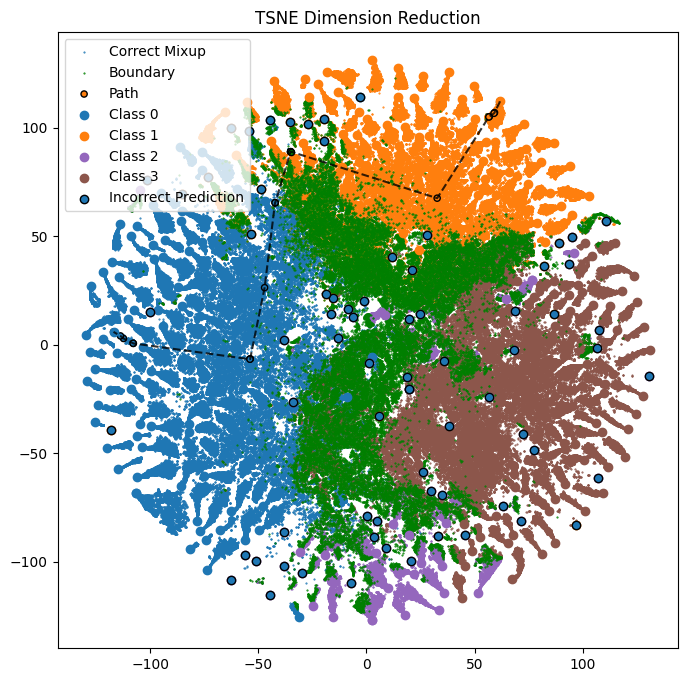

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")
ax.plot(path_df["projection_x"],path_df["projection_y"],alpha=0.8,linestyle="--",color="black")

ax.scatter(path_df["projection_x"],path_df["projection_y"],marker="o",s=20,c=["C0" if l == 0 else "C1" for l in path_df["argmax_pred"]], edgecolors = "black",label="Path")
ax.scatter(boundary_point["projection_x"],boundary_point["projection_y"],marker="o",s=20,c="green", edgecolors = "black")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [19]:
from scipy import spatial
from collections import Counter

# This may be a function that we want to change for different models, so we define it within the notebook.
def get_distances():

    all_images_without_B_df = df[df["type"] != "B"].reset_index()
    activations_A = [a for a in true_images_A_df["activations"]]
    activations_B = [a for a in true_images_B_df["activations"]]
    activations_mixup = [a for a in mixup_images_df["activations"]]
    activations_boundary = [a for a in boundary_images_df["activations"]]
    all = [a for a in all_images_without_B_df["activations"]]

    tree_true_A = spatial.KDTree(activations_A)
    tree_true_B = spatial.KDTree(activations_B)
    tree_mixup  = spatial.KDTree(activations_mixup)
    tree_boundaries = spatial.KDTree(activations_boundary)
    tree_all = spatial.KDTree(all)

    distances_to_all = []
    distances_B_to_boundary = []
    distances_B_to_mixup = []
    B_class_0_to_boundary = []
    B_class_1_to_boundary = []
    B_class_2_to_boundary = []
    B_class_3_to_boundary = []
    B_class_0_incorrect_to_boundary = []
    B_class_1_incorrect_to_boundary = []
    B_class_2_incorrect_to_boundary = []
    B_class_3_incorrect_to_boundary = []
    B_class_0_correct_to_boundary = []
    B_class_1_correct_to_boundary = []
    B_class_2_correct_to_boundary = []
    B_class_3_correct_to_boundary = []
    types = []
    distance_B_to_B = []
    
    distances_A_to_boundary = []
    A_class_0_to_boundary = []
    A_class_1_to_boundary = []
    A_class_2_to_boundary = []
    A_class_3_to_boundary = []
    A_class_0_incorrect_to_boundary = []
    A_class_1_incorrect_to_boundary = []
    A_class_2_incorrect_to_boundary = []
    A_class_3_incorrect_to_boundary = []
    distance_A_to_A = []

    for vector, label, pred in zip(activations_B,true_images_B_df["label"],true_images_B_df["argmax_pred"]):

        distance, id = tree_all.query(vector)
        types.append(all_images_without_B_df.loc[[id]]["type"][id])
        distances_to_all.append(distance)

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_B_to_B.append(tree_true_B.query(vector,2)[0][1])
        distances_B_to_boundary.append(boundary_dist)
        distances_B_to_mixup.append(tree_mixup.query(vector)[0])

        if label == 0:
            B_class_0_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_0_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_0_correct_to_boundary.append(boundary_dist)
        elif label == 1:
            B_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_1_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_1_correct_to_boundary.append(boundary_dist)
        elif label == 2:
            B_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_2_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_2_correct_to_boundary.append(boundary_dist)
        elif label == 3:
            B_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_3_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_3_correct_to_boundary.append(boundary_dist)

    for vector, label, pred in zip(activations_A, true_images_A_df["label"],true_images_A_df["argmax_pred"]):

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_A_to_A.append(tree_true_A.query(vector,2)[0][1])
        distances_A_to_boundary.append(boundary_dist)

        if label == 0:
            A_class_0_to_boundary.append(boundary_dist)
            if pred != label: #Incorrect
                A_class_0_incorrect_to_boundary.append(boundary_dist)
        elif label == 1:
            A_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_1_incorrect_to_boundary.append(boundary_dist)
        elif label == 2:
            A_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_2_incorrect_to_boundary.append(boundary_dist)
        elif label == 3:
            A_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_3_incorrect_to_boundary.append(boundary_dist)


    counts = Counter(types)

    print("Average Distance between Set B Images and all other images: ", np.mean(distances_to_all))
    print("Counts: ",counts)
    print("Average shortest distance from Set B Images to Boundary: ",np.mean(distances_B_to_boundary))
    print("Average shortest distance from Set B Images to Mixup Point: ",np.mean(distances_B_to_mixup))
    print("Average shortest distance from Set B Images to B Images: ",np.mean(distance_B_to_B))

    print("Average shortest distance from Test Set B Class 0 to Boundary: ",np.mean(B_class_0_to_boundary))
    print("Average shortest distance from Test Set B Class 1 to Boundary: ",np.mean(B_class_1_to_boundary))
    print("Average shortest distance from Test Set B Class 2 to Boundary: ",np.mean(B_class_2_to_boundary))
    print("Average shortest distance from Test Set B Class 3 to Boundary: ",np.mean(B_class_3_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 0 to Boundary: ",np.mean(B_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 1 to Boundary: ",np.mean(B_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 2 to Boundary: ",np.mean(B_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 3 to Boundary: ",np.mean(B_class_3_incorrect_to_boundary))
   
    print("\nAverage shortest distance from Set A Images to Boundary: ",np.mean(distances_A_to_boundary))
    print("Average shortest distance from Set A Images to A Images: ",np.mean(distance_A_to_A))
    print("Average shortest distance from Test Set A Class 0 to Boundary: ",np.mean(A_class_0_to_boundary))
    print("Average shortest distance from Test Set A Class 1 to Boundary: ",np.mean(A_class_1_to_boundary))
    print("Average shortest distance from Test Set A Class 2 to Boundary: ",np.mean(A_class_2_to_boundary))
    print("Average shortest distance from Test Set A Class 3 to Boundary: ",np.mean(A_class_3_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 0 to Boundary: ",np.mean(A_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 1 to Boundary: ",np.mean(A_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 2 to Boundary: ",np.mean(A_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 3 to Boundary: ",np.mean(A_class_3_incorrect_to_boundary))

    return distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary
   

In [20]:
distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary = get_distances()

Average Distance between Set B Images and all other images:  1.2725343963596818
Counts:  Counter({'mix': 647, 'A': 27, 'boundary': 26})
Average shortest distance from Set B Images to Boundary:  2.4330466437233613
Average shortest distance from Set B Images to Mixup Point:  1.2748720410458658
Average shortest distance from Set B Images to B Images:  1.523887831750157
Average shortest distance from Test Set B Class 0 to Boundary:  2.2535817548970187
Average shortest distance from Test Set B Class 1 to Boundary:  2.066402400803183
Average shortest distance from Test Set B Class 2 to Boundary:  1.8100595066290932
Average shortest distance from Test Set B Class 3 to Boundary:  3.559619724875377
Average shortest distance from Test Set B Incorrect Class 0 to Boundary:  1.8212259556678225
Average shortest distance from Test Set B Incorrect Class 1 to Boundary:  1.6018725956024522
Average shortest distance from Test Set B Incorrect Class 2 to Boundary:  1.8444400616149925
Average shortest dista

In [21]:
from scipy.stats import pearsonr

print(pearsonr(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1]["predictions_1"],B_class_1_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2]["predictions_2"],B_class_2_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3]["predictions_3"],B_class_3_to_boundary)[0])
print("")
print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3][true_images_B_df["argmax_pred"]==3]["predictions_3"],B_class_3_correct_to_boundary)[0])

0.3628911776547882
0.397598552847562
-0.07693752814400703
0.5961755948868659

0.548225780000403
0.5888680321726965
0.6324602405700396
0.6712250465845407


C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_35976\415269534.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_35976\415269534.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_35976\415269534.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_35976\415269534.py:11: UserWarning: Boolean S